In [2]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pathlib
import shutil
import random
import io
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Renommer les sous dossiers

In [2]:
dossier_parent = "C:/Users/Oliver/Desktop/Classify-Images-Using-Deep-Learning/Images"

# Parcourir tous les sous-dossiers
for dossier in os.listdir(dossier_parent):
    chemin_dossier = os.path.join(dossier_parent, dossier)
    
    # Vérifier si le chemin est un dossier
    if os.path.isdir(chemin_dossier):
        # Extraire le nouveau nom du dossier en utilisant une expression régulière
        nouveau_nom = re.sub(r"^\w+-", "", dossier)
        
        # Renommer le dossier
        nouveau_chemin_dossier = os.path.join(dossier_parent, nouveau_nom)
        os.rename(chemin_dossier, nouveau_chemin_dossier)
        print(f"Le dossier {dossier} a été renommé en {nouveau_nom}.")

Le dossier n02085620-Chihuahua a été renommé en Chihuahua.
Le dossier n02085782-Japanese_spaniel a été renommé en Japanese_spaniel.
Le dossier n02085936-Maltese_dog a été renommé en Maltese_dog.
Le dossier n02086079-Pekinese a été renommé en Pekinese.
Le dossier n02086240-Shih-Tzu a été renommé en Shih-Tzu.
Le dossier n02086646-Blenheim_spaniel a été renommé en Blenheim_spaniel.
Le dossier n02086910-papillon a été renommé en papillon.
Le dossier n02087046-toy_terrier a été renommé en toy_terrier.
Le dossier n02087394-Rhodesian_ridgeback a été renommé en Rhodesian_ridgeback.
Le dossier n02088094-Afghan_hound a été renommé en Afghan_hound.
Le dossier n02088238-basset a été renommé en basset.
Le dossier n02088364-beagle a été renommé en beagle.
Le dossier n02088466-bloodhound a été renommé en bloodhound.
Le dossier n02088632-bluetick a été renommé en bluetick.
Le dossier n02089078-black-and-tan_coonhound a été renommé en black-and-tan_coonhound.
Le dossier n02089867-Walker_hound a été ren

# Chargement des sous dossiers

In [2]:
# Chemin vers le dossier principal contenant les images par races
dataset_dir = "C:/Users/omira/Desktop/Classify-Images-Using-Deep-Learning/Images"

# Liste des noms des sous-dossiers (races)
subdirs = os.listdir(dataset_dir)

# Dictionnaire pour stocker les images prétraitées (y compris l'augmentation) par race
preprocessed_images_by_race = {}
preprocessed_images_by_race_clean = {}
preprocessed_images_by_race_resized = {}
preprocessed_images_by_race_gray = {}
preprocessed_images_by_race_equalized = {}
preprocessed_images_by_race_normalized = {}
preprocessed_images_by_race_whitened = {}
preprocessed_images_by_filename_augmented = {}

# listes pour stocker les différentes images afin de comprendre les différentes
# étapes du processus de traitement des images
images = []
clean_images_list = []
resized_images_list = []
gray_images_list = []
equalized_images_list = []
normalized_images_list = []
whitenened_images_list = []
augmented_images = []

# Traitement des images

In [3]:
# Paramètres de data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Nombre d'images augmentées par image d'origine
num_augmented_images = 4

In [5]:
# Taille de redimensionnement des images
new_size = (256, 256)

In [6]:
# Parcourir les sous-dossiers et charger les images
for subdir in subdirs[:10]:
    subdir_path = os.path.join(dataset_dir, subdir)
    
    # Vérifier si le chemin est un dossier
    if os.path.isdir(subdir_path):
        
        # Parcourir les fichiers dans le sous-dossier
        for file_name in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file_name)
            
            # Charger l'image en utilisant OpenCV
            image = cv2.imread(file_path)
            
            # Vérifier si l'image est valide
            if image is not None:
                # Redimensionner l'image
                clean_images_list.append(image)
                image_resized = cv2.resize(image, new_size)
                resized_images_list.append(image_resized)
                
                # Convertir en échelle de gris
                gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
                gray_images_list.append(gray_image)
                
                # Equalisation d'histogramme
                equalized_image = cv2.equalizeHist(gray_image)
                equalized_images_list.append(equalized_image)
                
                # Normalisation
                normalized_image = equalized_image / 255.0
                normalized_images_list.append(normalized_image)
                
                # Whitening
                mean = np.mean(normalized_image)
                std = np.std(normalized_image)
                whitened_image = (normalized_image - mean) / std
                
                # Ajuster la forme de l'image pour l'augmentation des données
                whitened_image = np.expand_dims(whitened_image, axis=2)
                whitenened_images_list.append(whitened_image)
                images.append(whitened_image)
                
                # Appliquer l'augmentation de données
                for _ in range(num_augmented_images):
                    augmented_image = datagen.random_transform(whitened_image)
                    augmented_images.append(augmented_image)
                preprocessed_images_by_filename_augmented[file_name] = [image] + augmented_images
                images.extend(augmented_images)
        
        # Stocker les images prétraitées (y compris l'augmentation) dans le dictionnaire par race
        preprocessed_images_by_race[subdir] = images
        preprocessed_images_by_race_clean[subdir] = clean_images_list
        preprocessed_images_by_race_resized[subdir] = resized_images_list
        preprocessed_images_by_race_gray[subdir] = gray_images_list
        preprocessed_images_by_race_equalized[subdir] = equalized_images_list
        preprocessed_images_by_race_normalized[subdir] = normalized_images_list
        preprocessed_images_by_race_whitened[subdir] = whitenened_images_list

# Visualisation des étapes de traitement

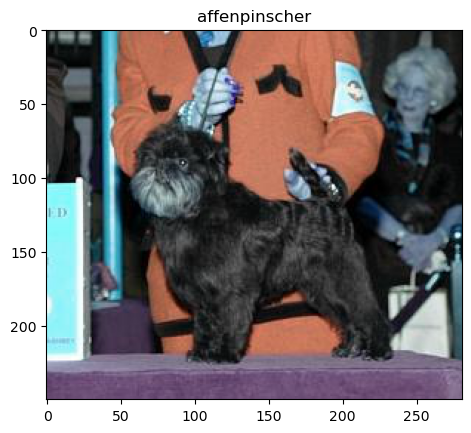

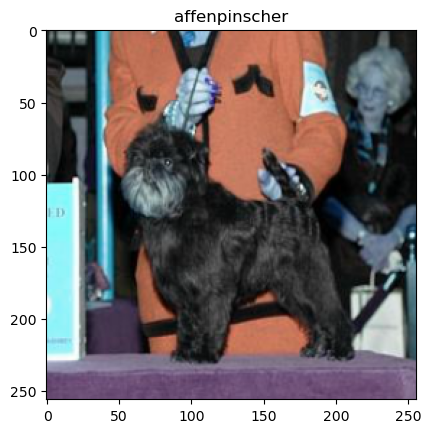

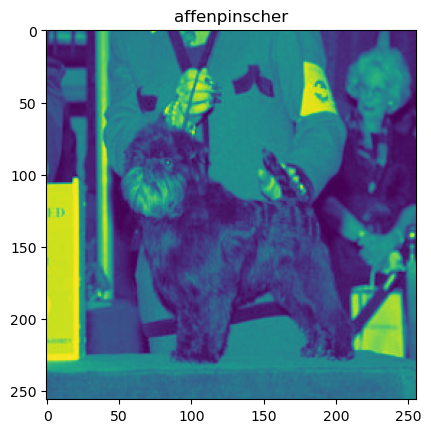

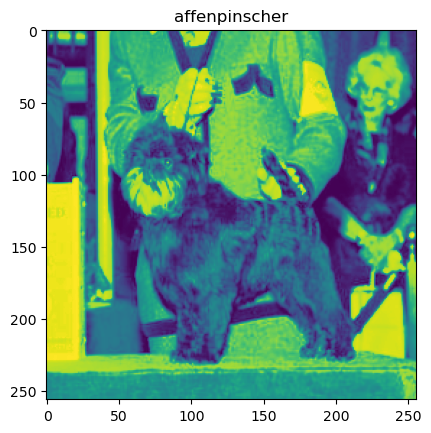

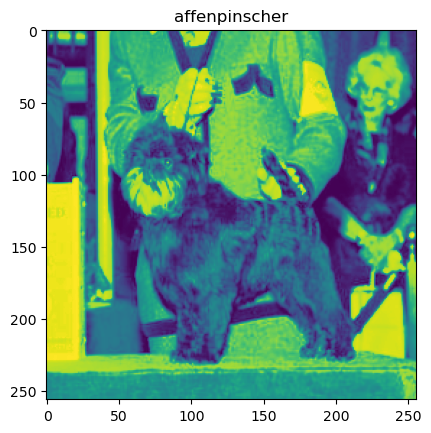

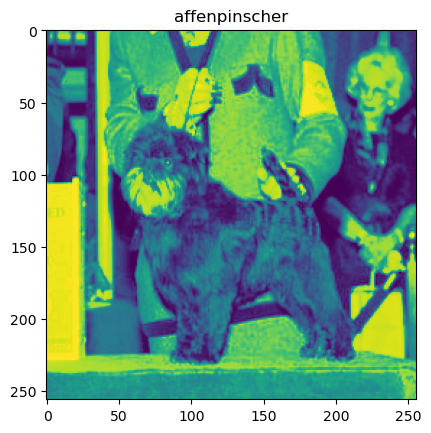

In [7]:
subdir = 'affenpinscher'

dictionaries = [preprocessed_images_by_race_clean, 
preprocessed_images_by_race_resized, preprocessed_images_by_race_gray, 
preprocessed_images_by_race_equalized, preprocessed_images_by_race_normalized, 
preprocessed_images_by_race_whitened]

for dictionary in dictionaries:
    if subdir in dictionary:
        img_list = dictionary[subdir]
        if len(img_list) > 0:
            img_test = img_list[0]
            plt.imshow(img_test)
            plt.title(subdir)
            plt.show()

# Visualisation de la data augmentation

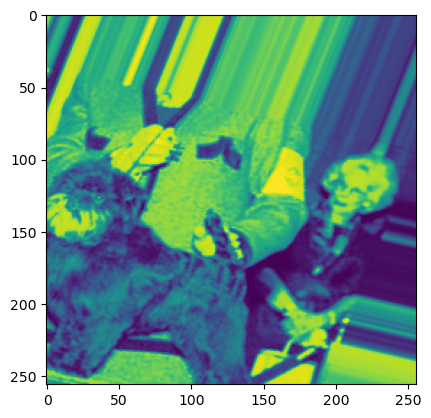

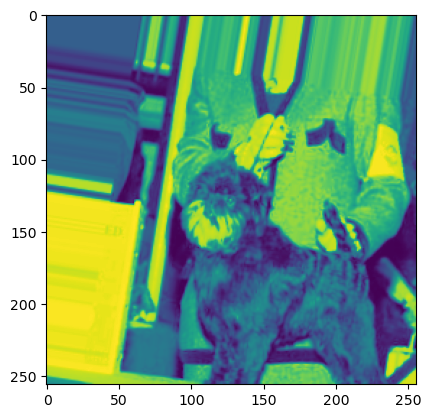

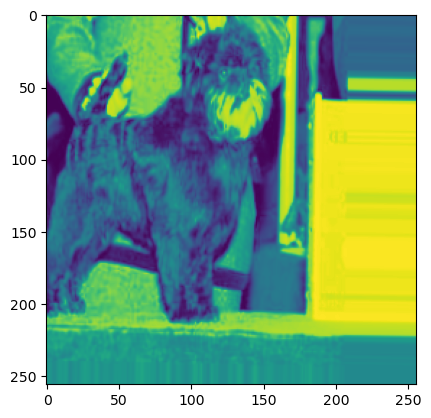

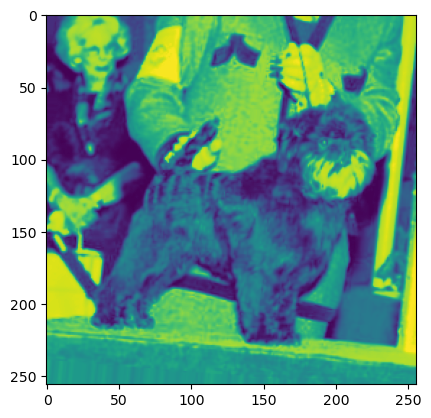

In [8]:
image_filenames = ['n02110627_10147.jpg']

for filename in image_filenames:
    for index in 1, 2, 3, 4:
        img_augmented = preprocessed_images_by_filename_augmented[filename][index]
        plt.imshow(img_augmented)
        plt.show()

# Création du modèle

## création du training set

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (256, 256),
  batch_size = 32)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


## création du validation set

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (256, 256),
  batch_size = 32)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

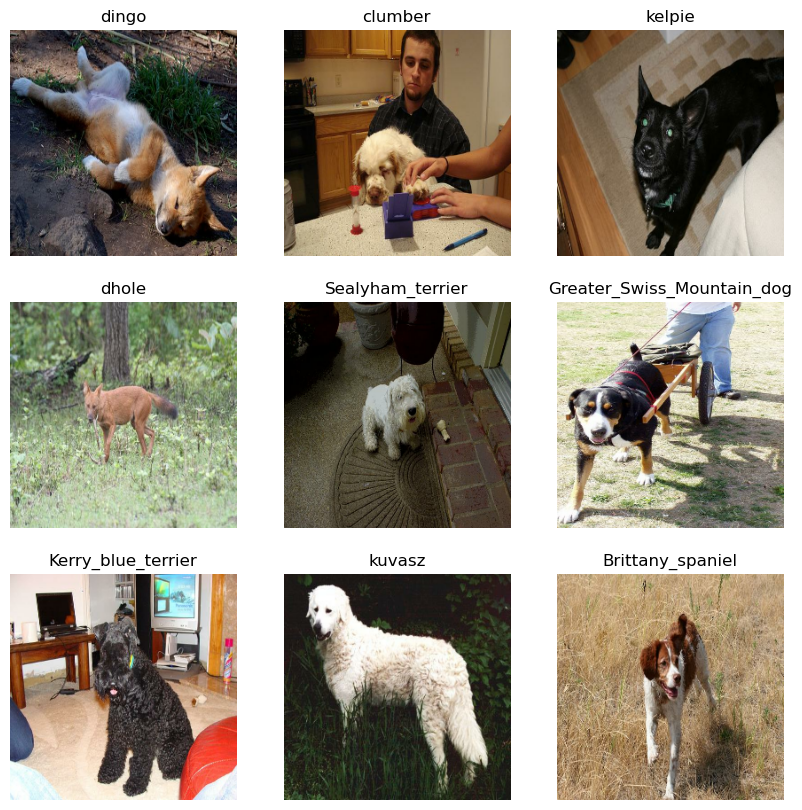

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [15]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 10
)

Epoch 1/10
515/515 [==============================] - 279s 537ms/step - loss: 4.7375 - accuracy: 0.0171 - val_loss: 4.5864 - val_accuracy: 0.0245
Epoch 2/10
515/515 [==============================] - 301s 581ms/step - loss: 4.3676 - accuracy: 0.0475 - val_loss: 4.2682 - val_accuracy: 0.0573
Epoch 3/10
515/515 [==============================] - 308s 595ms/step - loss: 3.9972 - accuracy: 0.0909 - val_loss: 4.1615 - val_accuracy: 0.0724
Epoch 4/10
515/515 [==============================] - 322s 622ms/step - loss: 3.3817 - accuracy: 0.1992 - val_loss: 4.4053 - val_accuracy: 0.0722
Epoch 5/10
515/515 [==============================] - 308s 595ms/step - loss: 2.2388 - accuracy: 0.4299 - val_loss: 5.2736 - val_accuracy: 0.0705
Epoch 6/10
515/515 [==============================] - 298s 577ms/step - loss: 1.0146 - accuracy: 0.7263 - val_loss: 7.7179 - val_accuracy: 0.0598
Epoch 7/10
515/515 [==============================] - 333s 645ms/step - loss: 0.3712 - accuracy: 0.9032 - val_loss: 10.2810 

In [ ]:
tf.keras.models.save_model(
    model,
    filepath="model_cnn_5_v1.00",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

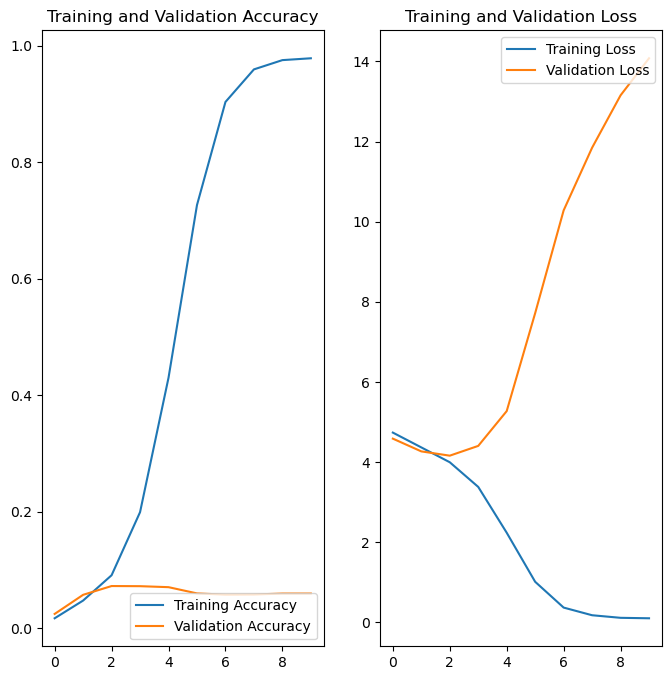

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

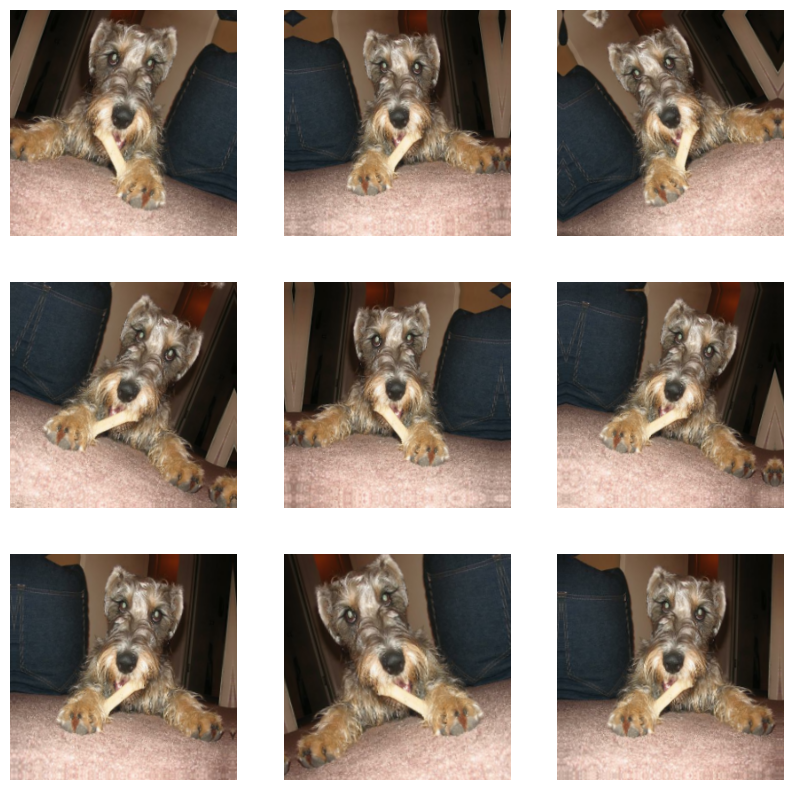

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [23]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 10
)

Epoch 1/10
515/515 [==============================] - 358s 688ms/step - loss: 4.7310 - accuracy: 0.0149 - val_loss: 4.5544 - val_accuracy: 0.0272
Epoch 2/10
515/515 [==============================] - 344s 662ms/step - loss: 4.3994 - accuracy: 0.0388 - val_loss: 4.2910 - val_accuracy: 0.0496
Epoch 3/10
515/515 [==============================] - 331s 640ms/step - loss: 4.2318 - accuracy: 0.0579 - val_loss: 4.2078 - val_accuracy: 0.0598
Epoch 4/10
515/515 [==============================] - 328s 635ms/step - loss: 4.1138 - accuracy: 0.0738 - val_loss: 4.1168 - val_accuracy: 0.0680
Epoch 5/10
515/515 [==============================] - 372s 721ms/step - loss: 4.0171 - accuracy: 0.0859 - val_loss: 4.0170 - val_accuracy: 0.0836
Epoch 6/10
515/515 [==============================] - 345s 668ms/step - loss: 3.9149 - accuracy: 0.1013 - val_loss: 4.0197 - val_accuracy: 0.0931
Epoch 7/10
515/515 [==============================] - 401s 776ms/step - loss: 3.8456 - accuracy: 0.1125 - val_loss: 3.9782 -

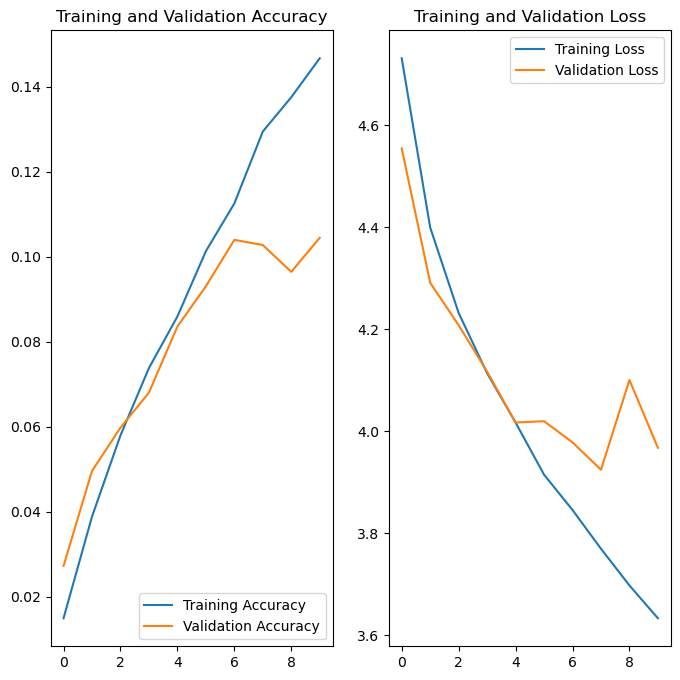

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
bull_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Bulldog_inglese.jpg/220px-Bulldog_inglese.jpg"
bull_path = tf.keras.utils.get_file('bul', origin=bull_url)

img = tf.keras.utils.load_img(
    bull_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to Blenheim_spaniel with a 27.33 percent confidence.


# Transfer Learning

### Train Test Split Folders

In [6]:
# Chemin vers le dossier principal contenant les sous-dossiers de races de chiens
input_folder = 'Images'

# Chemin vers le dossier où seront créés les ensembles de test et d'entraînement
output_folder = 'Train Test Split'

# Ratio de séparation entre test et train, ici 20% pour le test
ratio = 0.8

# Créer les dossiers de destination s'ils n'existent pas déjà
os.makedirs(output_folder + '/train', exist_ok=True)
os.makedirs(output_folder + '/test', exist_ok=True)

# Parcourir chaque sous-dossier de race de chien
for folder_name in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, folder_name)
    
    # Vérifier si c'est bien un sous-dossier
    if os.path.isdir(folder_path):
        # Créer les sous-dossiers correspondants dans l'ensemble d'entraînement et de test
        os.makedirs(os.path.join(output_folder, 'train', folder_name), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'test', folder_name), exist_ok=True)
        
        # Obtenir la liste des fichiers d'images dans le sous-dossier
        image_files = os.listdir(folder_path)
        random.shuffle(image_files)
        
        # Calculer le nombre d'images pour l'ensemble de test en fonction du ratio
        num_test_images = int(ratio * len(image_files))
        
        # Déplacer les images dans les dossiers d'entraînement et de test
        for i, image_file in enumerate(image_files):
            src_path = os.path.join(folder_path, image_file)
            if i < num_test_images:
                dst_path = os.path.join(output_folder, 'test', folder_name, image_file)
            else:
                dst_path = os.path.join(output_folder, 'train', folder_name, image_file)
            shutil.copy(src_path, dst_path)

In [85]:
data_dir = 'Train Test Split'
img_width, img_height = 224, 224
batch_size = 32
num_classes = 120

In [73]:
# Fonction de prétraitement des images pour le générateur de données
def preprocess_image(img):
    # Redimensionner l'image
    img = cv2.resize(img, (img_width, img_height))

    # Convertir en niveaux de gris (8 bits, un seul canal)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img_8bit = cv2.convertScaleAbs(gray_img)

    # Égalisation de l'histogramme
    equalized_img = cv2.equalizeHist(gray_img_8bit)

    # Whitening
    mean, std = cv2.meanStdDev(equalized_img)
    whitened_img = (equalized_img - mean) / std

    # Normalisation
    whitened_img = whitened_img / 255.0

    # Ajouter une dimension supplémentaire pour correspondre au format d'entrée du modèle (batch_size, width, height, channels)
    return whitened_img.reshape((img_width, img_height, 1))

In [86]:
# Augmentation de données pour améliorer la généralisation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    # preprocessing_function=preprocess_image
)

In [87]:
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
    # preprocessing_function=preprocess_image
)

In [88]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4162 images belonging to 120 classes.


In [115]:
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 16418 images belonging to 120 classes.


In [90]:
# Étape 3 : Charger le modèle pré-entraîné (VGG16 dans cet exemple)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [91]:
# Étape 4 : Adapter le modèle pour votre tâche de classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [92]:
# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

In [93]:
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
# Afficher un résumé du modèle
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [95]:
# Étape 5 : Entraîner le modèle
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size

In [96]:
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps
)

Epoch 1/10
130/130 [==============================] - 1821s 14s/step - loss: 5.1252 - accuracy: 0.0090 - val_loss: 4.7861 - val_accuracy: 0.0116
Epoch 2/10
130/130 [==============================] - 1788s 14s/step - loss: 4.7865 - accuracy: 0.0121 - val_loss: 4.7847 - val_accuracy: 0.0122
Epoch 3/10
130/130 [==============================] - 1840s 14s/step - loss: 4.7852 - accuracy: 0.0116 - val_loss: 4.7834 - val_accuracy: 0.0122
Epoch 4/10
130/130 [==============================] - 1835s 14s/step - loss: 4.7842 - accuracy: 0.0104 - val_loss: 4.7822 - val_accuracy: 0.0122
Epoch 5/10
130/130 [==============================] - 1846s 14s/step - loss: 4.7832 - accuracy: 0.0121 - val_loss: 4.7810 - val_accuracy: 0.0122
Epoch 6/10
130/130 [==============================] - 1860s 14s/step - loss: 4.7823 - accuracy: 0.0121 - val_loss: 4.7803 - val_accuracy: 0.0122
Epoch 7/10
130/130 [==============================] - 1812s 14s/step - loss: 4.7819 - accuracy: 0.0121 - val_loss: 4.7799 - val_ac

In [97]:
# Étape 6 : Évaluer le modèle
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.779185771942139
Test accuracy: 0.012242660857737064


In [116]:
# Classification Report
test_generator.reset()  # Réinitialise le générateur pour commencer depuis le début

# Récupérer les vraies étiquettes
y_true = test_generator.classes

# Récupérer les prédictions du modèle
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

class_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

514/514 [==============================] - 829s 2s/step
Classification Report:
                                precision    recall  f1-score   support

                  Afghan_hound       0.00      0.00      0.00       191
           African_hunting_dog       0.00      0.00      0.00       135
                      Airedale       0.00      0.00      0.00       161
American_Staffordshire_terrier       0.00      0.00      0.00       131
                   Appenzeller       0.00      0.00      0.00       120
            Australian_terrier       0.00      0.00      0.00       156
            Bedlington_terrier       0.00      0.00      0.00       145
          Bernese_mountain_dog       0.00      0.00      0.00       174
              Blenheim_spaniel       0.00      0.00      0.00       150
                 Border_collie       0.00      0.00      0.00       120
                Border_terrier       0.00      0.00      0.00       137
                   Boston_bull       0.00      0.00     

C:\Users\omira\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omira\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\omira\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
# Matrice de confusion
confusion_mat = confusion_matrix(y_true, y_pred)
print("Matrice de confusion:")
print(confusion_mat)

Matrice de confusion:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [100]:
# Sauvegarder le modèle dans un fichier HDF5
model.save('modele_chiens.h5')

In [101]:
tf.keras.models.save_model(
    model,
    filepath="model_transfer_v1.00",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: model_transfer_v1.00\assets


INFO:tensorflow:Assets written to: model_transfer_v1.00\assets


In [107]:
# Charger le modèle depuis le fichier HDF5
model = load_model('modele_chiens.h5')

In [ ]:
# Charger l'image
image_path = 'chemin/vers/une/image.jpg'
img = cv2.imread(image_path)

# Prétraiter l'image
preprocessed_img = preprocess_image(img)

# Effectuer la prédiction
prediction = model.predict(np.expand_dims(preprocessed_img, axis=0))
predicted_class_index = np.argmax(prediction)

### Approche 2

In [3]:
# Chemin vers le dossier principal contenant les sous-dossiers d'images de chiens
data_dir = "Images"

In [5]:
# Charger les images et leurs étiquettes depuis le dossier
def load_data(data_dir):
    images = []
    labels = []
    breed_list = sorted(os.listdir(data_dir))
    for breed_idx, breed in enumerate(breed_list):
        breed_folder = os.path.join(data_dir, breed)
        for img_file in os.listdir(breed_folder):
            img_path = os.path.join(breed_folder, img_file)
            img = tf.keras.preprocessing.image.load_img(
                img_path, target_size=(img_height, img_width)
            )
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
            images.append(img)
            labels.append(breed_idx)
    return np.array(images), np.array(labels)

In [6]:
# Charger les données
images, labels = load_data(data_dir)

MemoryError: Unable to allocate 15.1 GiB for an array with shape (20580, 256, 256, 3) and data type float32

In [4]:
# Paramètres
img_height, img_width = 256, 256
batch_size = 32
epochs = 20

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
datagen.fit(X_train)

In [ ]:
# Créer le modèle basé sur le MobileNetV2 en utilisant le transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(set(labels)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entraîner le modèle
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs)

In [ ]:
# Évaluer le modèle
_, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

In [ ]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Fonction pour télécharger l'image depuis l'URL et la prétraiter
def preprocess_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(io.BytesIO(response.content))
    img = img.resize((img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
# Charger la liste des noms de races de chiens
breed_list = sorted(os.listdir(data_dir))

In [ ]:
# URL de l'image à prédire
image_url = "https://upload.wikimedia.org/wikipedia/commons/e/e8/Afghan_dog_-_cropped.jpg"

# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class])

9406464/9406464 [==============================] - 3s 0us/step
Epoch 1/10
515/515 [==============================] - 80s 137ms/step - loss: 1.8736 - accuracy: 0.5115
Epoch 2/10
515/515 [==============================] - 71s 136ms/step - loss: 1.2617 - accuracy: 0.6318
Epoch 3/10
515/515 [==============================] - 72s 137ms/step - loss: 1.1176 - accuracy: 0.6703
Epoch 4/10
515/515 [==============================] - 72s 137ms/step - loss: 1.0403 - accuracy: 0.6874
Epoch 5/10
515/515 [==============================] - 72s 137ms/step - loss: 0.9669 - accuracy: 0.7092
Epoch 6/10
515/515 [==============================] - 72s 137ms/step - loss: 0.8939 - accuracy: 0.7306
Epoch 7/10
515/515 [==============================] - 71s 136ms/step - loss: 0.8542 - accuracy: 0.7379
Epoch 8/10
515/515 [==============================] - 72s 137ms/step - loss: 0.7983 - accuracy: 0.7499
Epoch 9/10
515/515 [==============================] - 71s 136ms/step - loss: 0.7652 - accuracy: 0.7677
Epoch 10/1

1/1 [==============================] - 2s 2s/step
Prédiction: Afghan_hound


In [127]:
# URL de l'image à prédire
image_url = "https://www.thesprucepets.com/thmb/5s_34Cf4OqS8e3p4zaJ-El5eGXw=/2121x0/filters:no_upscale():strip_icc()/GettyImages-988045138-5be0740146e0fb0026ddae02.jpg"

# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Charger la liste des noms de races de chiens
data_dir = "Images"
breed_list = sorted(os.listdir(data_dir))

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class])

1/1 [==============================] - 1s 797ms/step
Prédiction: Afghan_hound


In [128]:
# URL de l'image à prédire
image_url = "https://images.ctfassets.net/440y9b545yd9/Y9gB3irmojuBsdPo6pc39/b5ef99988db3a04a3357b07ea0abe0c3/Afghan_Hound850__1_.jpg"

# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Charger la liste des noms de races de chiens
data_dir = "Images"
breed_list = sorted(os.listdir(data_dir))

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class])

1/1 [==============================] - 1s 788ms/step
Prédiction: Afghan_hound


In [129]:
 # URL de l'image à prédire
image_url = "https://www.snobdogacademy.fr/app/uploads/2023/04/race-de-chien-affenpinscher-1024x1024.png"

# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Charger la liste des noms de races de chiens
data_dir = "Images"
breed_list = sorted(os.listdir(data_dir))

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class])

1/1 [==============================] - 1s 826ms/step
Prédiction: affenpinscher
